In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import time
import warnings
warnings.filterwarnings("ignore")

# NOTES
**1. I test with different Scale Method + Sampling technique for Model ML, it will take a long time if use loop to test so I split to small case to test**

**2. You will see that it has the same name like X_train_1, y_train_1,.. for each cases, but actually I always reset from step 1 to certain I take a True test for each case. For Example, after test with non scale case, next case is minmaxscale, I reset from step 1( u will see later) and scale data, sampling,.., testing with model**

In [3]:
data = pd.read_csv('/kaggle/input/data-final/train.csv')

# Data Problems
**1. Imbalance** - USE SMOTE

**2. Code Gender contain "XNA" value**

**3. DAY_BIRTH negative**

**4. DAY_EMPLOYED contain value > 1000 years**

**5. NaN value**

# Preprocessing

**1. Drop "XNA" value**

In [6]:
data = data[data['CODE_GENDER'] != "XNA"]

**2. DAY_BIRTH**

In [7]:
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])

**3. Fill NaN DAY_EMPLOYED contain value > 1000 years**

In [8]:
data.replace(max(data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

**4. Handling NaN value**

In [9]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns['Data Type'] = df.dtypes[mis_val_table_ren_columns.index]
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
      
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [10]:
missing_values = missing_values_table(data)
missing_values

Your selected dataframe has 46 columns.
There are 21 columns that have missing values.


,Missing Values,% of Total Values,Data Type
OWN_CAR_AGE,104018,66.0,float64
EXT_SOURCE_1,88686,56.3,float64
OCCUPATION_TYPE,49360,31.3,object
EXT_SOURCE_3,31143,19.8,float64
DAYS_EMPLOYED,28237,17.9,float64
AMT_REQ_CREDIT_BUREAU_YEAR,21118,13.4,float64
AMT_REQ_CREDIT_BUREAU_QRT,21118,13.4,float64
AMT_REQ_CREDIT_BUREAU_MON,21118,13.4,float64
AMT_REQ_CREDIT_BUREAU_WEEK,21118,13.4,float64
AMT_REQ_CREDIT_BUREAU_DAY,21118,13.4,float64


In [21]:
missing_values.iloc[:, 0]

OWN_CAR_AGE                   104018
EXT_SOURCE_1                   88686
OCCUPATION_TYPE                49360
EXT_SOURCE_3                   31143
DAYS_EMPLOYED                  28237
AMT_REQ_CREDIT_BUREAU_YEAR     21118
AMT_REQ_CREDIT_BUREAU_QRT      21118
AMT_REQ_CREDIT_BUREAU_MON      21118
AMT_REQ_CREDIT_BUREAU_WEEK     21118
AMT_REQ_CREDIT_BUREAU_DAY      21118
AMT_REQ_CREDIT_BUREAU_HOUR     21118
NAME_TYPE_SUITE                  646
DEF_60_CNT_SOCIAL_CIRCLE         523
OBS_30_CNT_SOCIAL_CIRCLE         523
OBS_60_CNT_SOCIAL_CIRCLE         523
DEF_30_CNT_SOCIAL_CIRCLE         523
EXT_SOURCE_2                     338
AMT_GOODS_PRICE                  133
AMT_ANNUITY                        8
DAYS_LAST_PHONE_CHANGE             1
CNT_FAM_MEMBERS                    1
Name: Missing Values, dtype: int64

**Drop columns which have percentage NaN value >= 50%**

**Fill NaN value for categorical features has % NaN < 2% = mode**

**Fill NaN value for categorical features has % NaN > 2% = "Missing"**

**Fill NaN value for numerical features = mean**

In [12]:
data = data.drop(['OWN_CAR_AGE', 'EXT_SOURCE_1'], axis=1)

In [24]:
nan_nums = ['EXT_SOURCE_3','DAYS_EMPLOYED', 'AMT_REQ_CREDIT_BUREAU_YEAR',    
'AMT_REQ_CREDIT_BUREAU_QRT',   'AMT_REQ_CREDIT_BUREAU_MON',     
'AMT_REQ_CREDIT_BUREAU_WEEK',  'AMT_REQ_CREDIT_BUREAU_DAY',      
'AMT_REQ_CREDIT_BUREAU_HOUR',  'DEF_60_CNT_SOCIAL_CIRCLE',  
'OBS_30_CNT_SOCIAL_CIRCLE',    'OBS_60_CNT_SOCIAL_CIRCLE',        
'DEF_30_CNT_SOCIAL_CIRCLE',    'EXT_SOURCE_2',                     
'AMT_GOODS_PRICE',   'AMT_ANNUITY',  'DAYS_LAST_PHONE_CHANGE',            
'CNT_FAM_MEMBERS']
for nan_num in nan_nums:
    data[nan_num] = data[nan_num].fillna(data[nan_num].mean())

In [31]:
data['NAME_TYPE_SUITE'].fillna('Missing', inplace=True)
data['OCCUPATION_TYPE'].fillna('Missing', inplace=True)

# MODEL

In [22]:
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
]

In [30]:
def score(X_train, X_test, y_train, y_test, names = names, models = models):
    score_df, score_test = pd.DataFrame(), []
    x = time.time()
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        prediction = model.predict_proba(X_test)[:, 1]
        score_test.append({
            'Classifier': model.__class__.__name__,
            'Accuracy': accuracy_score(y_test, y_test_pred),
            'ROC-AUC': roc_auc_score(y_test, prediction),
        })

        # Plot ROC-AUC curve for each model
        fpr, tpr, thresholds = roc_curve(y_test, prediction)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(4, 3))
        plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver operating characteristic for {names[i]}')
        plt.legend(loc="lower right")
        plt.show()

    score_df = pd.DataFrame(score_test)
    score_df.sort_values(by='Accuracy', ascending=False, inplace=True)
    return score_df

# Predict Using All Orginal Features

**Step:**
1. Encoding Categorical features by One Hot Encoder
2. Split train test with different size 70:30, 80:20
3. Scale data by MinMax Scaler, Standardlize
4. Data Imbalance Handing
5. Use different Machine Learning algorithms

**Step 1**

In [98]:
data_encode = pd.get_dummies(data)

**Step 2**

In [99]:
data_encode.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637.0,...,False,False,False,False,False,False,False,False,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188.0,...,False,False,False,False,False,False,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225.0,...,False,False,False,False,False,False,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039.0,...,False,False,False,False,False,False,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038.0,...,False,False,False,False,False,False,False,False,False,False


In [100]:
# 70 - 30
X_1 = data_encode.drop(['SK_ID_CURR','TARGET'], axis=1)
y_1 = data_encode['TARGET']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, stratify=y_1, random_state=42)

print("X=",X_train_1.shape, X_test_1.shape)
print("y=",y_train_1.shape, y_test_1.shape)

X= (110255, 155) (47253, 155)
y= (110255,) (47253,)


In [101]:
# 80 - 20
X_2 = data_encode.drop(['SK_ID_CURR','TARGET'], axis=1)
y_2 = data_encode['TARGET']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, stratify=y_2, random_state=42)

print("X=",X_train_2.shape, X_test_2.shape)
print("y=",y_train_2.shape, y_test_2.shape)

X= (126006, 155) (31502, 155)
y= (126006,) (31502,)


**Step 3**

In [104]:
scaler1 = MinMaxScaler()

In [105]:
cols = X_train_1.columns
X_train_1[cols] = scaler1.fit_transform(X_train_1[cols])
X_test_1[cols] = scaler1.transform(X_test_1[cols])

In [50]:
cols = X_train_2.columns
X_train_2[cols] = scaler1.fit_transform(X_train_2[cols])
X_test_2[cols] = scaler1.transform(X_test_2[cols])

In [57]:
scaler2 = StandardScaler()

In [58]:
cols = X_train_1.columns
X_train_1[cols] = scaler2.fit_transform(X_train_1[cols])
X_test_1[cols] = scaler2.transform(X_test_1[cols])

In [59]:
cols = X_train_2.columns
X_train_2[cols] = scaler2.fit_transform(X_train_2[cols])
X_test_2[cols] = scaler2.transform(X_test_2[cols])

**Step 4**

In [106]:
sm = SMOTE(random_state=42)

In [107]:
# minmax For 70-30
X_train_1,y_train_1 = sm.fit_resample(X_train_1,y_train_1)

In [53]:
y_train_1.value_counts(normalize=True)

TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64

In [51]:
# minmax For 80-20
X_train_2,y_train_2 = sm.fit_resample(X_train_2,y_train_2)

In [55]:
y_train_2.value_counts(normalize=True)

TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64

In [61]:
# standard For 70-30
X_train_1,y_train_1 = sm.fit_resample(X_train_1,y_train_1)

In [62]:
# standard For 80-20
X_train_2,y_train_2 = sm.fit_resample(X_train_2,y_train_2)

**Step 5**

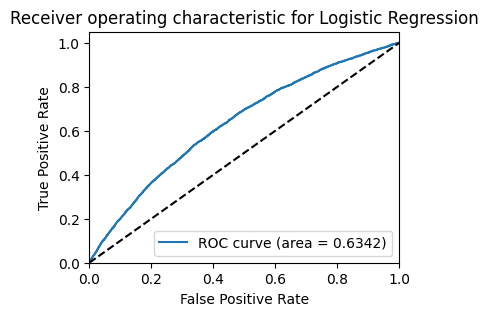

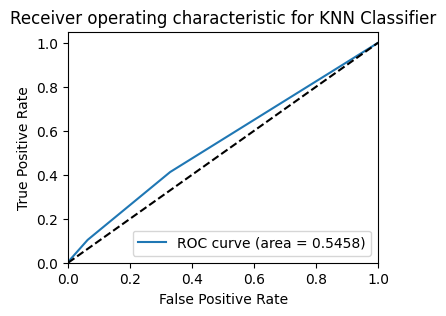

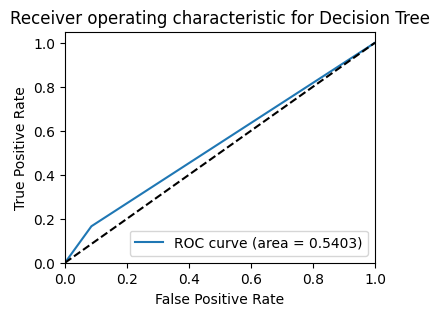

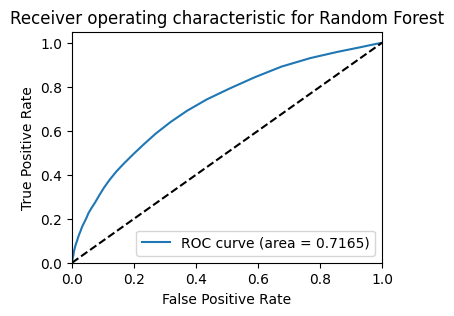

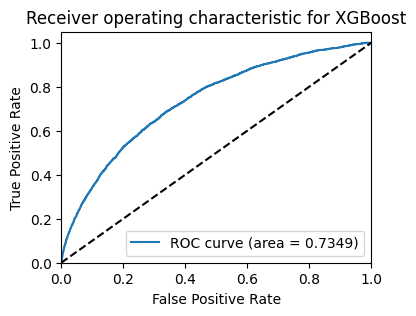

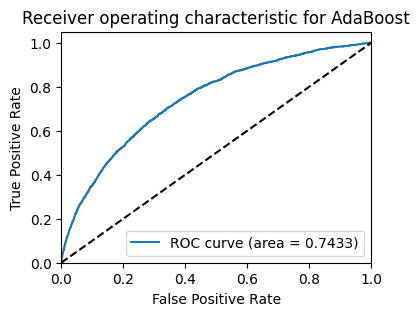

,Classifier,Accuracy,ROC-AUC
0,LogisticRegression,0.918418,0.634177
3,RandomForestClassifier,0.918376,0.716507
5,AdaBoostClassifier,0.918354,0.743307
4,XGBClassifier,0.917529,0.734936
1,KNeighborsClassifier,0.912916,0.545786
2,DecisionTreeClassifier,0.853724,0.540308


In [31]:
# no scale&sampling 70-30
score(X_train_1, X_test_1, y_train_1, y_test_1, names = names, models = models)

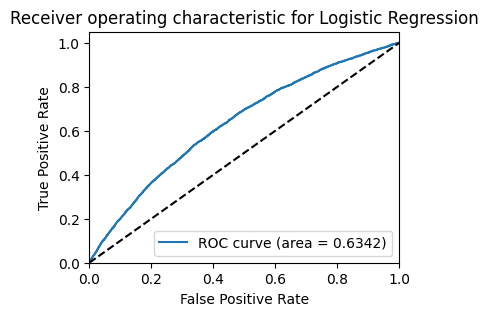

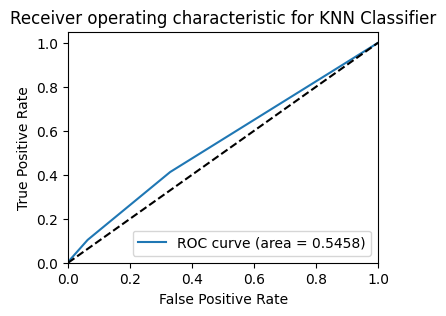

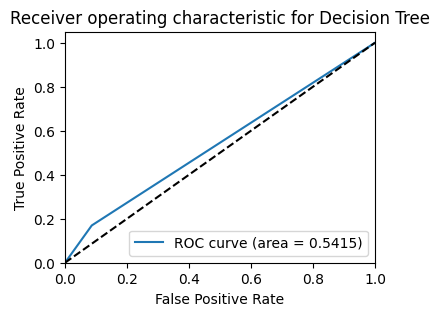

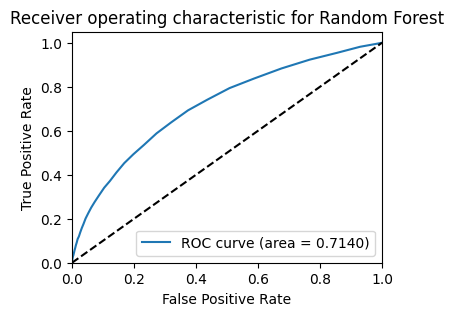

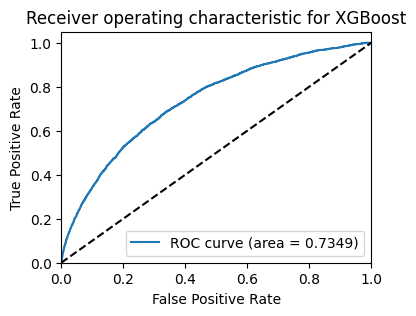

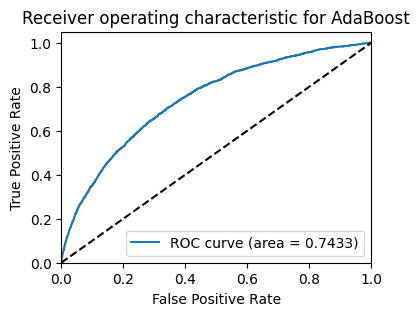

,Classifier,Accuracy,ROC-AUC
3,RandomForestClassifier,0.918481,0.713979
0,LogisticRegression,0.918418,0.634177
5,AdaBoostClassifier,0.918354,0.743307
4,XGBClassifier,0.917529,0.734936
1,KNeighborsClassifier,0.912916,0.545786
2,DecisionTreeClassifier,0.852962,0.541548


In [48]:
# no scale&sampling 80-20
score(X_train_1, X_test_1, y_train_1, y_test_1, names = names, models = models)

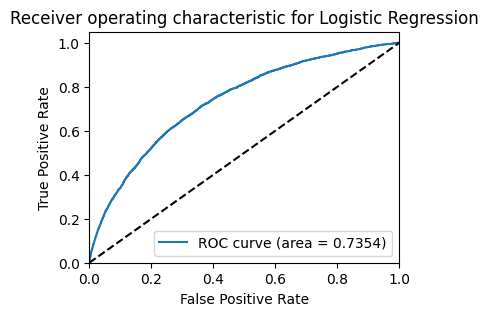

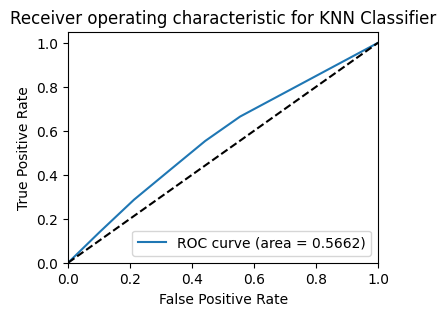

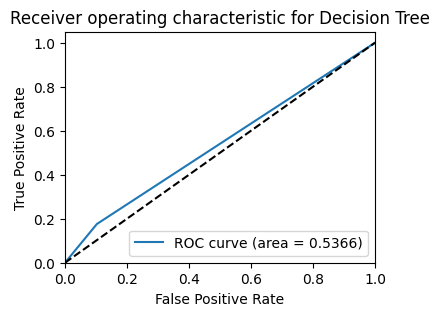

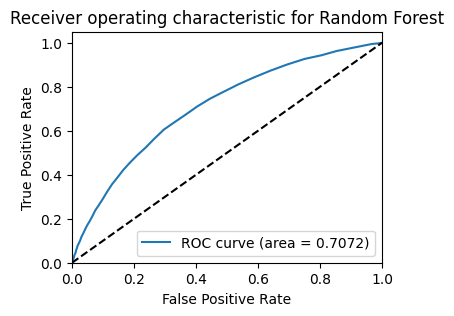

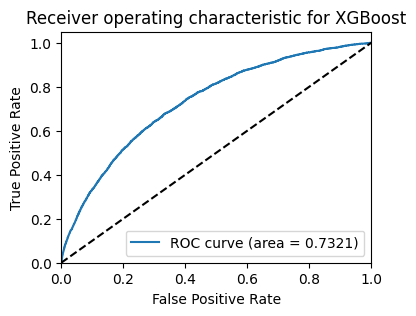

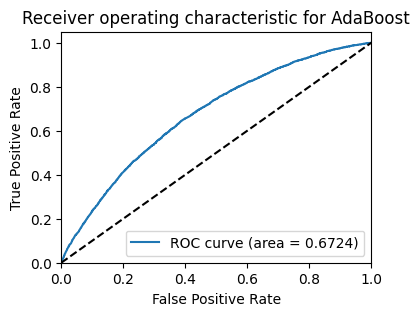

,Classifier,Accuracy,ROC-AUC
4,XGBClassifier,0.917571,0.732070
3,RandomForestClassifier,0.917508,0.707249
5,AdaBoostClassifier,0.859840,0.672387
2,DecisionTreeClassifier,0.838381,0.536565
0,LogisticRegression,0.692358,0.735413
1,KNeighborsClassifier,0.650879,0.566233


In [42]:
# minmax 70-30
score(X_train_1, X_test_1, y_train_1, y_test_1, names = names, models = models)

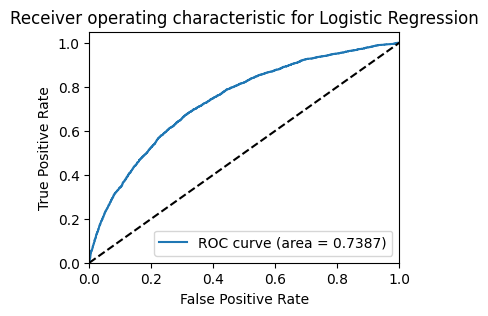

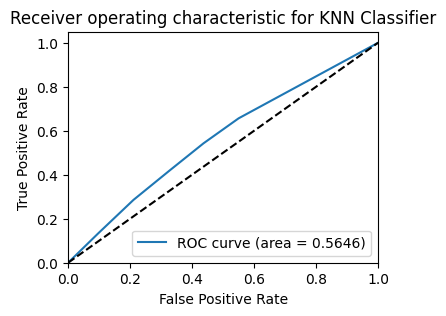

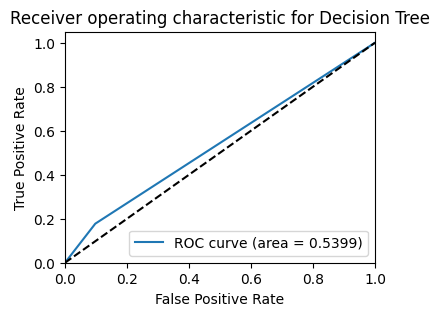

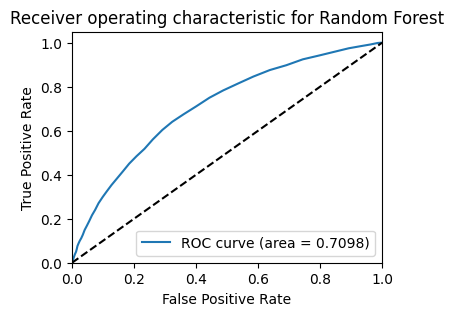

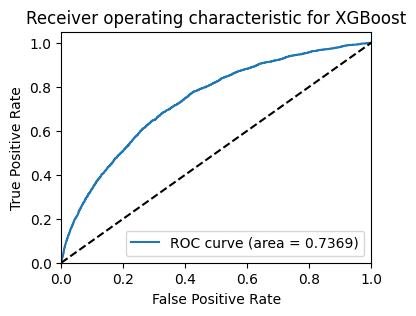

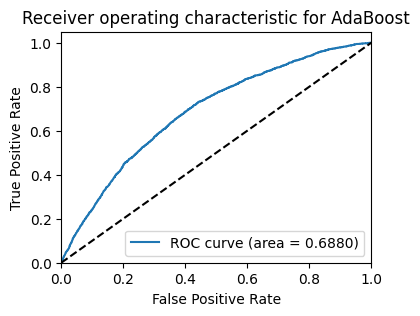

,Classifier,Accuracy,ROC-AUC
3,RandomForestClassifier,0.917497,0.709807
4,XGBClassifier,0.916323,0.736883
5,AdaBoostClassifier,0.862929,0.688030
2,DecisionTreeClassifier,0.843185,0.539896
0,LogisticRegression,0.693416,0.738730
1,KNeighborsClassifier,0.652784,0.564566


In [52]:
# minmax 80-20
score(X_train_2, X_test_2, y_train_2, y_test_2, names = names, models = models)

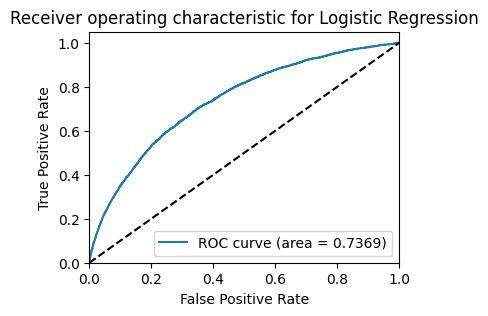

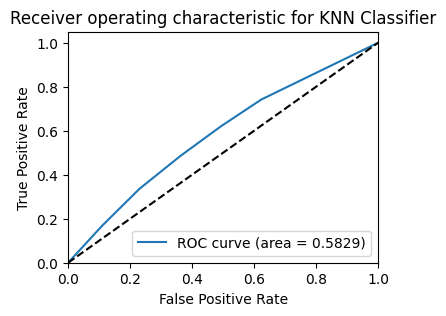

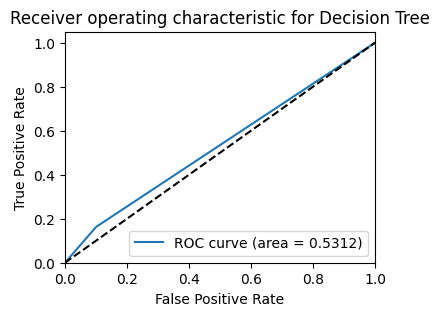

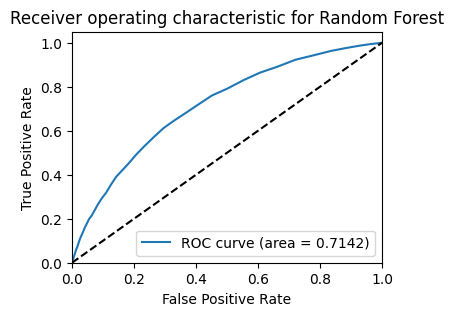

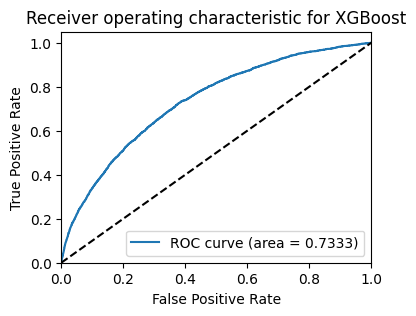

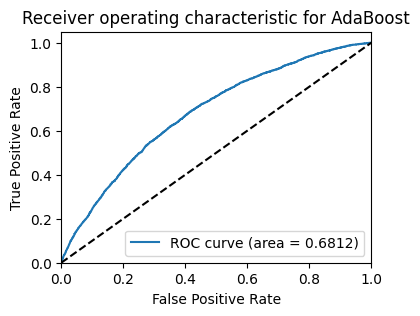

,Classifier,Accuracy,ROC-AUC
3,RandomForestClassifier,0.917614,0.714217
4,XGBClassifier,0.916725,0.733342
5,AdaBoostClassifier,0.862421,0.681236
2,DecisionTreeClassifier,0.839418,0.531219
0,LogisticRegression,0.690559,0.736928
1,KNeighborsClassifier,0.626288,0.582930


In [63]:
# standard 70-30
score(X_train_1, X_test_1, y_train_1, y_test_1, names = names, models = models)

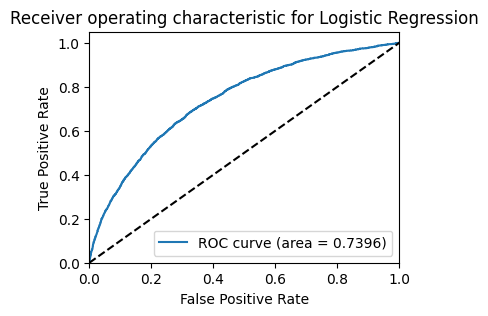

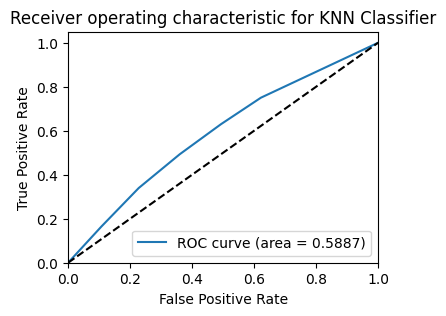

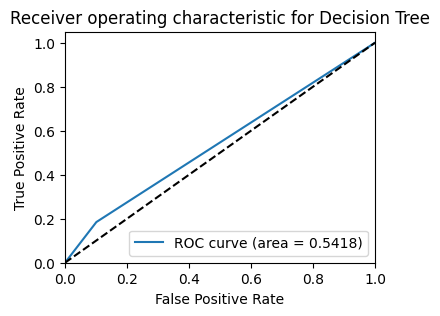

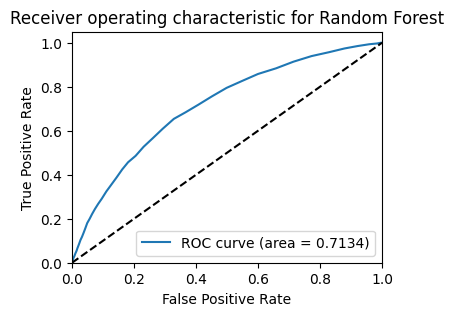

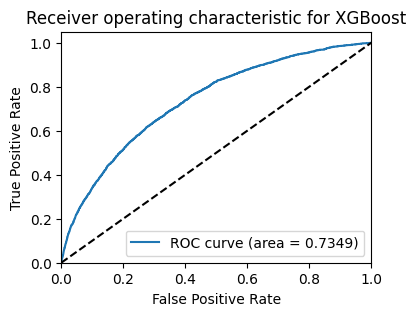

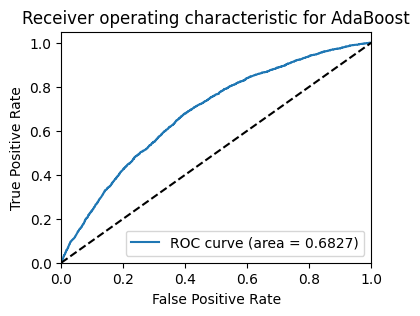

,Classifier,Accuracy,ROC-AUC
3,RandomForestClassifier,0.917815,0.713353
4,XGBClassifier,0.916862,0.734868
5,AdaBoostClassifier,0.865564,0.682736
2,DecisionTreeClassifier,0.840582,0.541849
0,LogisticRegression,0.691575,0.739552
1,KNeighborsClassifier,0.628182,0.588679


In [64]:
# standard 80-20
score(X_train_2, X_test_2, y_train_2, y_test_2, names = names, models = models)

# Predict by Feature Selection using WOE

1. Calculate WoE for each features
2. Calculate IV
3. Drop feature has IV < 0.02
4. Predict ML

In [110]:
data = pd.read_csv('/kaggle/input/dataclean/data.csv')

In [111]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns
    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
    

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(data, target='TARGET', bins=20)

Information value of SK_ID_CURR is 0.000998
Information value of NAME_CONTRACT_TYPE is 0.01585
Information value of CODE_GENDER is 0.039547
Information value of FLAG_OWN_CAR is 0.007159
Information value of FLAG_OWN_REALTY is 0.000404
Information value of CNT_CHILDREN is 0.001431
Information value of AMT_INCOME_TOTAL is 0.010765
Information value of AMT_CREDIT is 0.06031
Information value of AMT_ANNUITY is 0.032649
Information value of AMT_GOODS_PRICE is 0.107278
Information value of NAME_TYPE_SUITE is 0.001727
Information value of NAME_INCOME_TYPE is 0.057243
Information value of NAME_EDUCATION_TYPE is 0.050073
Information value of NAME_FAMILY_STATUS is 0.024653
Information value of NAME_HOUSING_TYPE is 0.015067
Information value of REGION_POPULATION_RELATIVE is 0.048776
Information value of DAYS_BIRTH is 0.089503
Information value of DAYS_EMPLOYED is 0.107336
Information value of DAYS_REGISTRATION is 0.027933
Information value of DAYS_ID_PUBLISH is 0.041378
Information value of FLAG_

**DROP IV < 0.02**

In [112]:
low_IV_cols =  ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
      'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE', 'NAME_HOUSING_TYPE',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
        'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
          'OBS_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_HOUR',   
'AMT_REQ_CREDIT_BUREAU_QRT',   'AMT_REQ_CREDIT_BUREAU_MON',   'AMT_REQ_CREDIT_BUREAU_WEEK']

In [113]:
data_woe = data.drop(low_IV_cols, axis = 1)

**Step:**
1. Encoding Categorical features by One Hot Encoder
2. Split train test with different size 70:30, 80:20
3. Scale data by MinMax Scaler
4. Data Imbalance Handing
5. Use different Machine Learning algorithms

**Step 1**

In [114]:
data_encode = pd.get_dummies(data_woe)

**Step 2**

In [115]:
# 70 - 30
Xw_1 = data_encode.drop(['TARGET'], axis=1)
yw_1 = data_encode['TARGET']

X_trainw_1, X_testw_1, y_trainw_1, y_testw_1 = train_test_split(Xw_1, yw_1, test_size=0.3, stratify=yw_1, random_state=42)

print("X=",X_trainw_1.shape, X_testw_1.shape)
print("y=",y_trainw_1.shape, y_testw_1.shape)

X= (110255, 113) (47253, 113)
y= (110255,) (47253,)


In [116]:
# 80 - 20
Xw_2 = data_encode.drop(['TARGET'], axis=1)
yw_2 = data_encode['TARGET']

X_trainw_2, X_testw_2, y_trainw_2, y_testw_2 = train_test_split(Xw_2, yw_2, test_size=0.2, stratify=yw_2, random_state=42)

print("X=",X_trainw_2.shape, X_testw_2.shape)
print("y=",y_trainw_2.shape, y_testw_2.shape)

X= (126006, 113) (31502, 113)
y= (126006,) (31502,)


**Step 3**

In [119]:
scaler1 = MinMaxScaler()

In [120]:
cols = X_trainw_1.columns
X_trainw_1[cols] = scaler1.fit_transform(X_trainw_1[cols])
X_testw_1[cols] = scaler1.transform(X_testw_1[cols])

In [76]:
cols = X_trainw_2.columns
X_trainw_2[cols] = scaler1.fit_transform(X_trainw_2[cols])
X_testw_2[cols] = scaler1.transform(X_testw_2[cols])

In [89]:
scaler2 = StandardScaler()

In [90]:
cols = X_trainw_1.columns
X_trainw_1[cols] = scaler2.fit_transform(X_trainw_1[cols])
X_testw_1[cols] = scaler2.transform(X_testw_1[cols])

In [91]:
cols = X_trainw_2.columns
X_trainw_2[cols] = scaler2.fit_transform(X_trainw_2[cols])
X_testw_2[cols] = scaler2.transform(X_testw_2[cols])

**Step 4**

In [121]:
sm = SMOTE(random_state=42)

In [122]:
# minmax scaler + 70-30
X_trainw_1,y_trainw_1 = sm.fit_resample(X_trainw_1,y_trainw_1)

In [79]:
# minmax scaler + 80-20
X_trainw_2,y_trainw_2 = sm.fit_resample(X_trainw_2,y_trainw_2)

In [92]:
# standard scaler + 70-30
X_trainw_1,y_trainw_1 = sm.fit_resample(X_trainw_1,y_trainw_1)

In [93]:
# standard scaler + 80-20
X_trainw_2,y_trainw_2 = sm.fit_resample(X_trainw_2,y_trainw_2)

**Step 5**

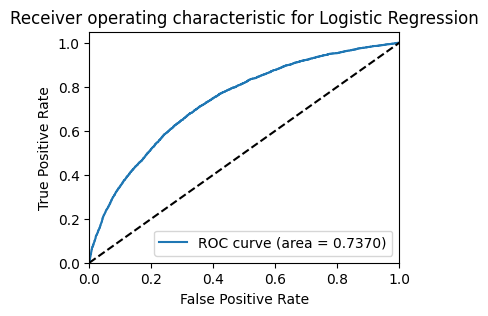

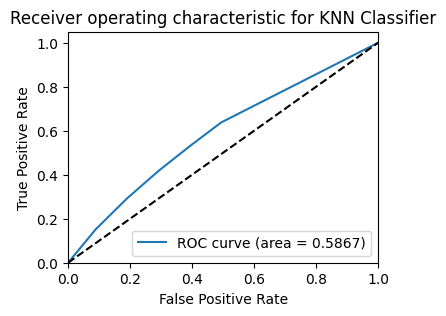

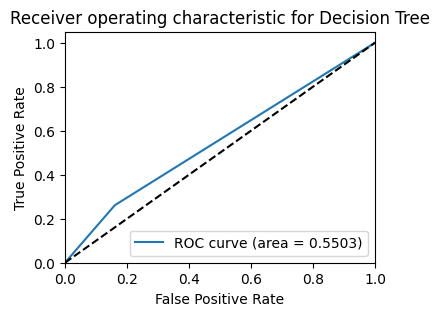

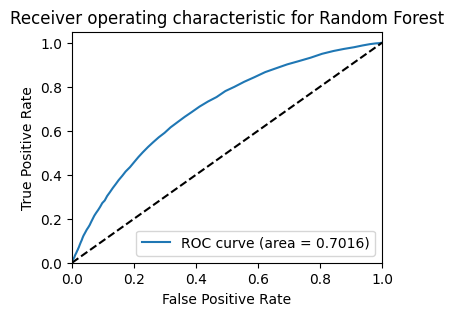

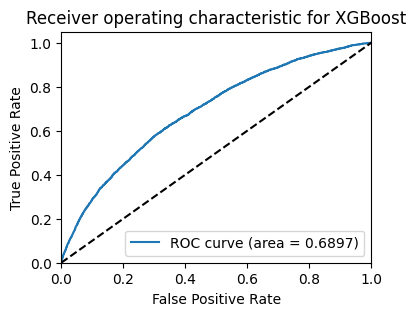

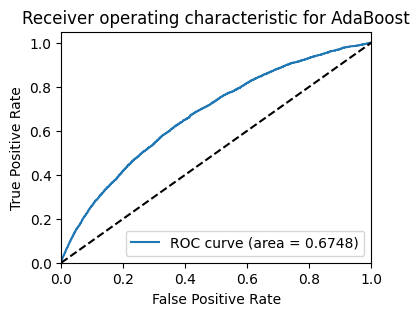

,Classifier,Accuracy,ROC-AUC
4,XGBClassifier,0.893255,0.689716
3,RandomForestClassifier,0.887097,0.701571
2,DecisionTreeClassifier,0.792204,0.550319
5,AdaBoostClassifier,0.774215,0.674780
0,LogisticRegression,0.685290,0.737030
1,KNeighborsClassifier,0.682369,0.586651


In [80]:
# minmax 70-30
score(X_trainw_1, X_testw_1, y_trainw_1, y_testw_1, names = names, models = models)

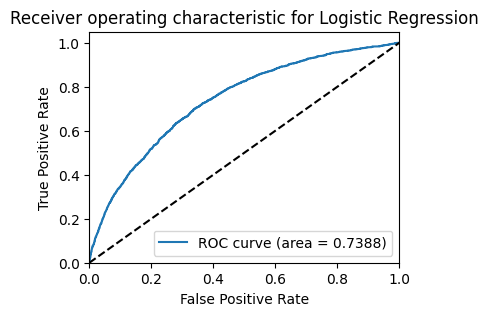

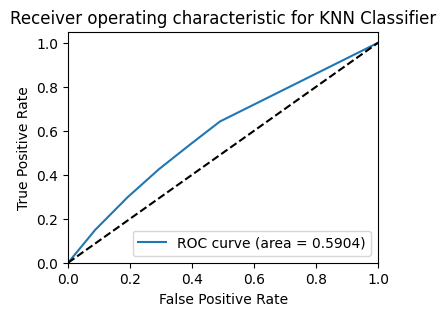

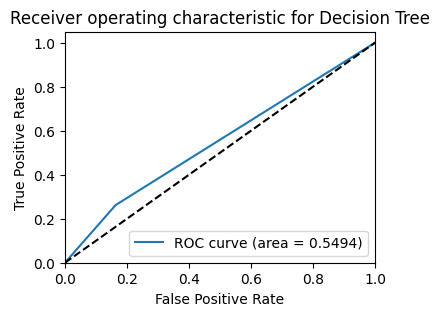

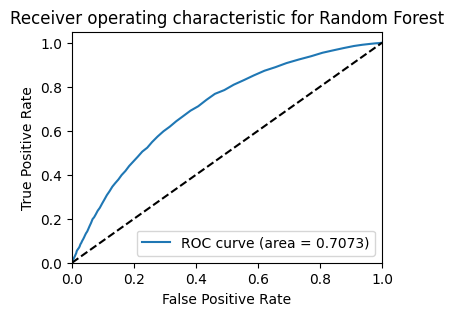

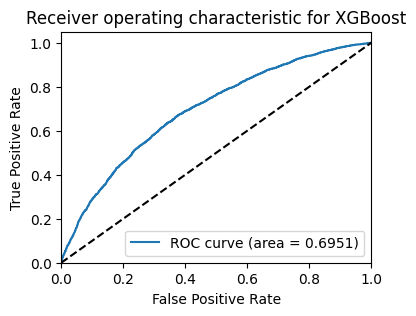

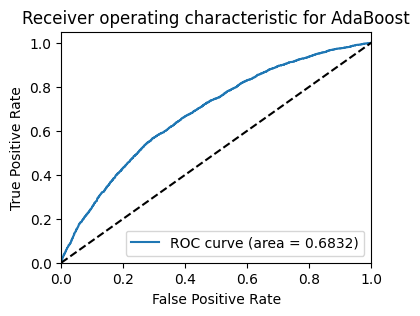

,Classifier,Accuracy,ROC-AUC
4,XGBClassifier,0.890261,0.695051
3,RandomForestClassifier,0.885245,0.707299
2,DecisionTreeClassifier,0.789918,0.549382
5,AdaBoostClassifier,0.778744,0.683159
1,KNeighborsClassifier,0.684084,0.590449
0,LogisticRegression,0.683576,0.738804


In [81]:
# minmax 80-20
score(X_trainw_2, X_testw_2, y_trainw_2, y_testw_2, names = names, models = models)

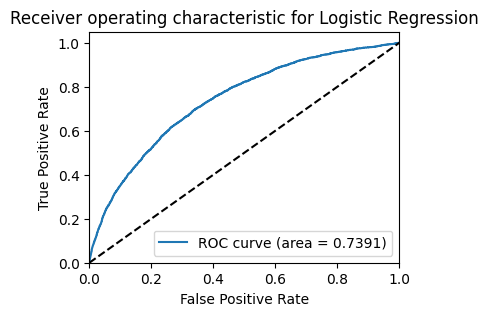

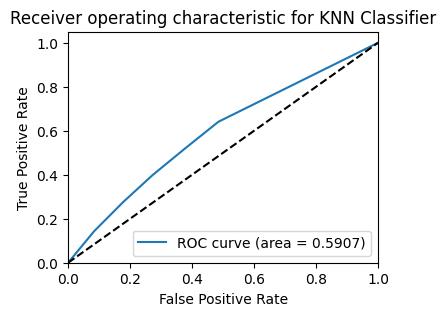

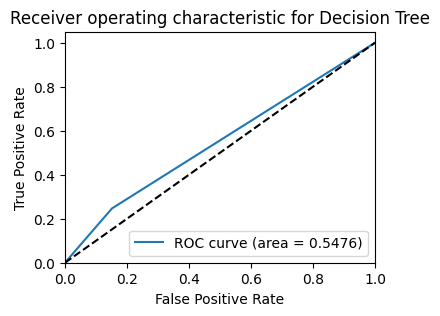

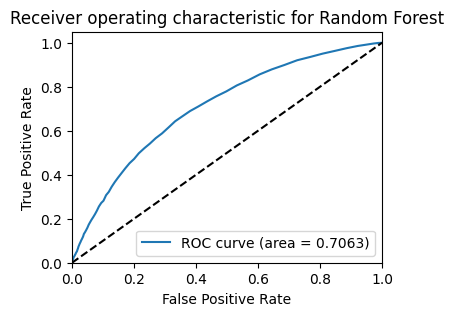

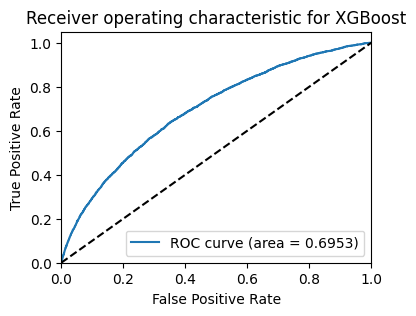

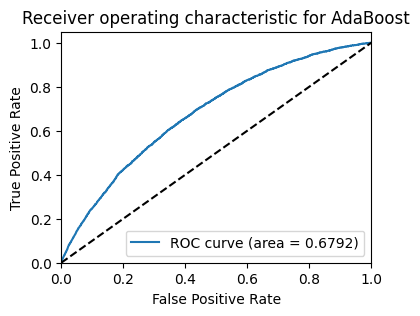

,Classifier,Accuracy,ROC-AUC
4,XGBClassifier,0.900430,0.695307
3,RandomForestClassifier,0.895478,0.706273
2,DecisionTreeClassifier,0.799420,0.547628
5,AdaBoostClassifier,0.781580,0.679225
1,KNeighborsClassifier,0.700421,0.590747
0,LogisticRegression,0.685840,0.739076


In [94]:
# standard 70-30
score(X_trainw_1, X_testw_1, y_trainw_1, y_testw_1, names = names, models = models)

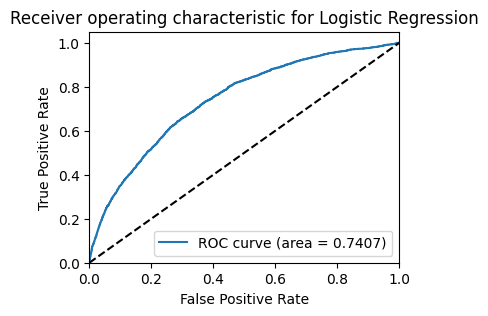

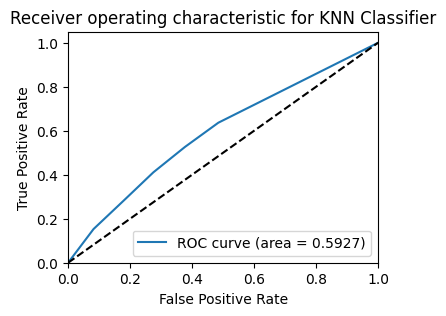

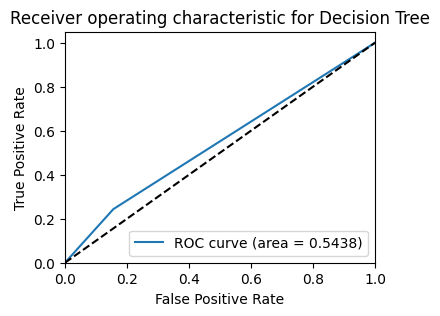

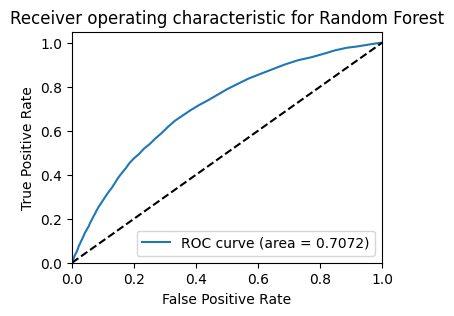

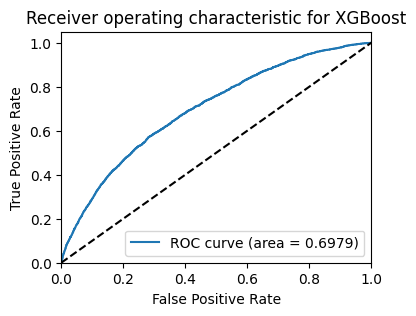

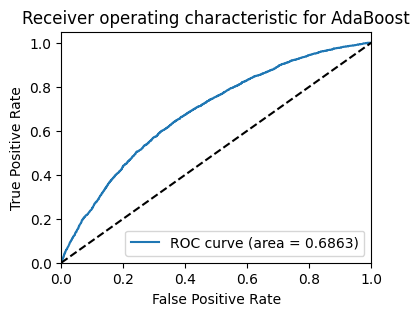

,Classifier,Accuracy,ROC-AUC
4,XGBClassifier,0.898419,0.697882
3,RandomForestClassifier,0.895276,0.707217
2,DecisionTreeClassifier,0.795029,0.543829
5,AdaBoostClassifier,0.784363,0.686298
1,KNeighborsClassifier,0.699289,0.592714
0,LogisticRegression,0.688401,0.740738


In [95]:
# standard 80-20
score(X_trainw_2, X_testw_2, y_trainw_2, y_testw_2, names = names, models = models)

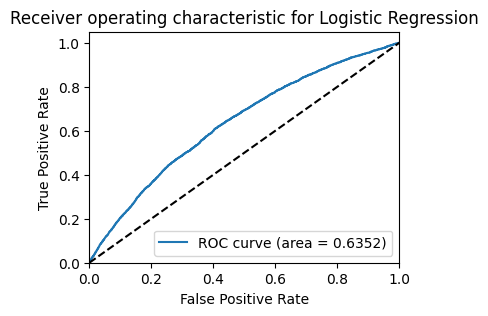

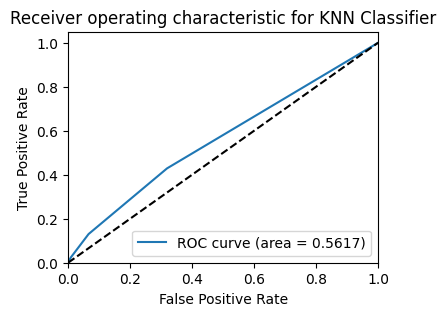

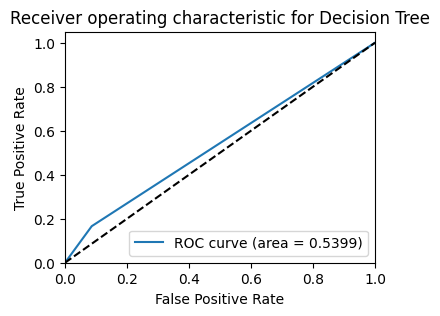

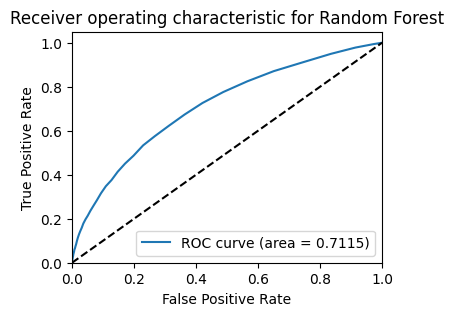

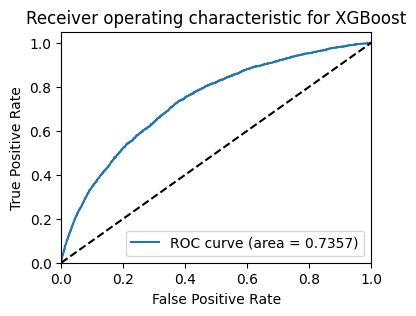

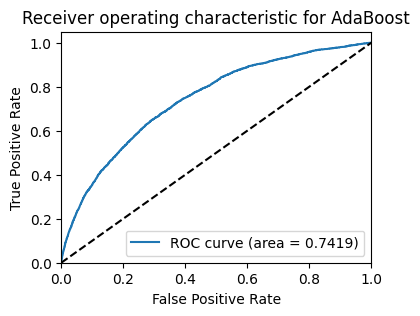

,Classifier,Accuracy,ROC-AUC
3,RandomForestClassifier,0.918481,0.711542
0,LogisticRegression,0.918397,0.635194
5,AdaBoostClassifier,0.918206,0.741904
4,XGBClassifier,0.917741,0.735662
1,KNeighborsClassifier,0.912323,0.561746
2,DecisionTreeClassifier,0.852814,0.539931


In [72]:
# no scale 70-30
score(X_trainw_1, X_testw_1, y_trainw_1, y_testw_1, names = names, models = models)

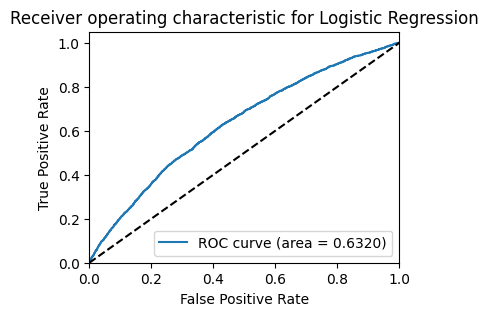

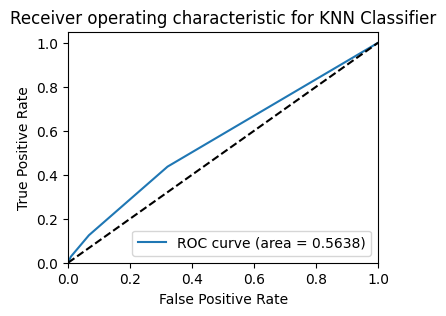

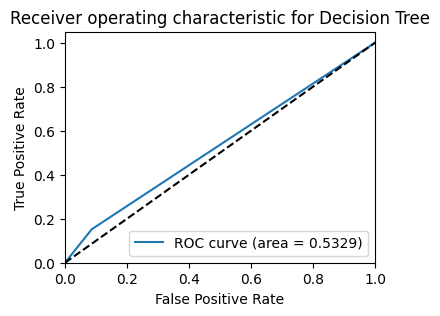

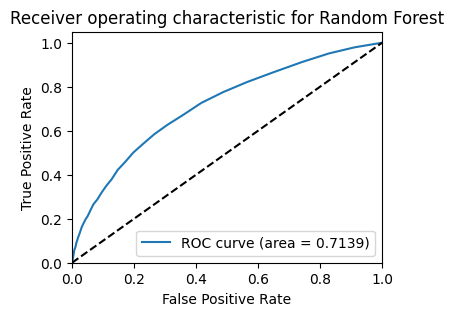

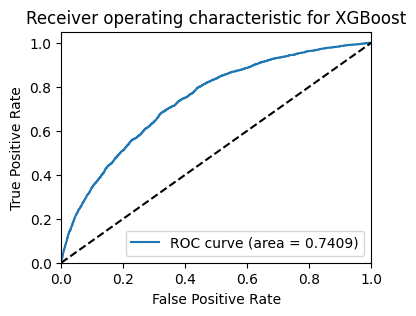

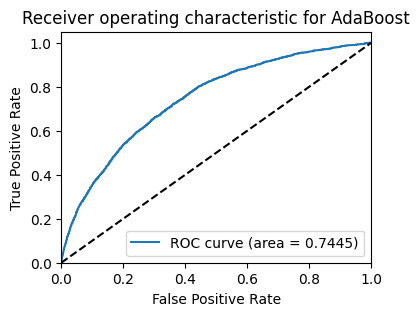

,Classifier,Accuracy,ROC-AUC
0,LogisticRegression,0.918418,0.632008
3,RandomForestClassifier,0.918386,0.713921
5,AdaBoostClassifier,0.918291,0.744495
4,XGBClassifier,0.917529,0.740852
1,KNeighborsClassifier,0.912577,0.563794
2,DecisionTreeClassifier,0.851501,0.532896


In [73]:
# no scale 80-20
score(X_trainw_2, X_testw_2, y_trainw_2, y_testw_2, names = names, models = models)

# Evaluation
- Some model has high accuracy but low ROC-AUC score, so we will evaluate by F1 score, recall and precision

**ORGINAL FEATURES**
1. No scale/sampling: Check Adaboost
2. Min-Max Scaler/Standard Scaler: Check XGBClassifier & RandomForest

P/S: Result for 70-30 and 80-20 have a small deviation so i will check in size 70-30 and minmax

**WOE feature selection**
1. Min-Max Scaler/Standard Scaler: Check XGBClassifier & Logistic (Result for 70-30 and 80-20 have a small deviation so i will check in size 70-30) and minmax
2. No scale/sampling: Check Adaboost, Random in size 70-30 


In [102]:
ada_model = AdaBoostClassifier()
xgb_model = XGBClassifier(random_seed=42)
random_model = RandomForestClassifier()
log_model = LogisticRegression()

In [103]:
# ORG features/no scale
ada_model.fit(X_train_1, y_train_1)
y_test_pred = ada_model.predict(X_test_1)
print(confusion_matrix(y_test_1, y_test_pred))
print(classification_report(y_test_1, y_test_pred))

[[43323    76]
 [ 3782    72]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     43399
           1       0.49      0.02      0.04      3854

    accuracy                           0.92     47253
   macro avg       0.70      0.51      0.50     47253
weighted avg       0.88      0.92      0.88     47253



In [108]:
# ORG features/minmaxscale + smote
xgb_model.fit(X_train_1, y_train_1)
y_test_pred = xgb_model.predict(X_test_1)
print(confusion_matrix(y_test_1, y_test_pred))
print(classification_report(y_test_1, y_test_pred))

[[43214   185]
 [ 3710   144]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     43399
           1       0.44      0.04      0.07      3854

    accuracy                           0.92     47253
   macro avg       0.68      0.52      0.51     47253
weighted avg       0.88      0.92      0.88     47253



In [109]:
# ORG features/minmaxscale + smote
random_model.fit(X_train_1, y_train_1)
y_test_pred = random_model.predict(X_test_1)
print(confusion_matrix(y_test_1, y_test_pred))
print(classification_report(y_test_1, y_test_pred))

[[43325    74]
 [ 3830    24]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     43399
           1       0.24      0.01      0.01      3854

    accuracy                           0.92     47253
   macro avg       0.58      0.50      0.48     47253
weighted avg       0.86      0.92      0.88     47253



In [117]:
# WOEfeatures/no scale 70-30
random_model.fit(X_trainw_1, y_trainw_1)
y_testw_pred = random_model.predict(X_testw_1)
print(confusion_matrix(y_testw_1, y_testw_pred))
print(classification_report(y_testw_1, y_testw_pred))

[[43396     3]
 [ 3847     7]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     43399
           1       0.70      0.00      0.00      3854

    accuracy                           0.92     47253
   macro avg       0.81      0.50      0.48     47253
weighted avg       0.90      0.92      0.88     47253



In [118]:
# WOEfeatures/no scale
ada_model.fit(X_trainw_1, y_trainw_1)
y_testw_pred = ada_model.predict(X_testw_1)
print(confusion_matrix(y_testw_1, y_testw_pred))
print(classification_report(y_testw_1, y_testw_pred))

[[43324    75]
 [ 3790    64]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     43399
           1       0.46      0.02      0.03      3854

    accuracy                           0.92     47253
   macro avg       0.69      0.51      0.49     47253
weighted avg       0.88      0.92      0.88     47253



In [123]:
# WOE features/minmaxscale + smote 70-30
xgb_model.fit(X_trainw_1, y_trainw_1)
y_testw_pred = xgb_model.predict(X_testw_1)
print(confusion_matrix(y_testw_1, y_testw_pred))
print(classification_report(y_testw_1, y_testw_pred))

[[41673  1726]
 [ 3318   536]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     43399
           1       0.24      0.14      0.18      3854

    accuracy                           0.89     47253
   macro avg       0.58      0.55      0.56     47253
weighted avg       0.87      0.89      0.88     47253



In [124]:
# WOE features/minmaxscale +smote
log_model.fit(X_trainw_1, y_trainw_1)
y_testw_pred = log_model.predict(X_testw_1)
print(confusion_matrix(y_testw_1, y_testw_pred))
print(classification_report(y_testw_1, y_testw_pred))

[[29819 13580]
 [ 1291  2563]]
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     43399
           1       0.16      0.67      0.26      3854

    accuracy                           0.69     47253
   macro avg       0.56      0.68      0.53     47253
weighted avg       0.89      0.69      0.76     47253

